In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from src.utils.filters import MovingAvgTime, get_factors, MovingAvgFreq

In [ ]:
df = pd.read_csv(
    # "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
df.plot()

MAD in Time

In [ ]:
ks = [1]+get_factors(288) + [288]
real_steps = list(range(2, 289))
fig, axs = plt.subplots(ceil(len(ks)/3), 3, figsize=(15, 15))
axs = axs.flatten()
betas = torch.load('/home/user/data/FrequencyDiffusion/savings/std_schedule.pt')
# betas = torch.sqrt(1-betas**2)
raw_ = torch.from_numpy(df.values).reshape(1,-1,1)
mean = torch.mean(raw_, dim=1, keepdim=True)
stdev = torch.sqrt(torch.var(raw_, dim=1, keepdim=True, unbiased=False) + 1e-6)
x_norm = (raw_ - mean) / stdev

for i, k in enumerate(ks):
    mat = MovingAvgTime(k)
    filtered_ = mat(x_norm)
    # filtered_ = torch.nn.functional.interpolate(
    #             filtered_.permute(0, 2, 1),
    #             size=288 - k + 1, mode='nearest-exact'
    #         )[..., :: k]
    if i > 0:
        # print(betas[real_steps.index(k)])
        
        noise = torch.randn_like(filtered_.flatten())*betas[real_steps.index(k)]
    else:
        noise = 0
    axs[i].plot(filtered_.flatten() + noise)
    axs[i].set_title(f'ks={k}')
    axs[i].set_ylim(-3,3)
fig.tight_layout()

In [ ]:
ks = [1]+get_factors(288) + [288]
real_steps = list(range(2, 289))
fig, axs = plt.subplots(ceil(len(ks)/3), 3, figsize=(15, 15))
axs = axs.flatten()
betas = torch.load('/home/user/data/FrequencyDiffusion/savings/empirical.pt')
# betas = torch.sqrt(1-betas**2)
raw_ = torch.from_numpy(df.values).reshape(1,-1,1)
mean = torch.mean(raw_, dim=1, keepdim=True)
stdev = torch.sqrt(torch.var(raw_, dim=1, keepdim=True, unbiased=False) + 1e-6)
x_norm = (raw_ - mean) / stdev

for i, k in enumerate(ks):
    mat = MovingAvgTime(k)
    filtered_ = mat(x_norm)
    # filtered_ = torch.nn.functional.interpolate(
    #             filtered_.permute(0, 2, 1),
    #             size=288 - k + 1, mode='nearest-exact'
    #         )[..., :: k]
    if i > 0:
        # print(betas[real_steps.index(k)])
        
        noise = torch.randn_like(filtered_.flatten())*betas[real_steps.index(k)]
    else:
        noise = 0
    axs[i].plot(filtered_.flatten() + noise)
    axs[i].set_title(f'ks={k}')
    axs[i].set_ylim(-3,3)
fig.tight_layout()

MAD in Freq

In [3]:
fig, axs = plt.subplots(ceil(len(ks)/3), 3, figsize=(15, 15))
axs = axs.flatten()
for i, k in enumerate(ks):
    maf = MovingAvgFreq(k, freq=torch.fft.rfftfreq(288))
    R = torch.diag(maf.Hw.flatten())
    df_fft = torch.from_numpy(df.values).reshape(1,-1,1)
    df_fft = torch.fft.rfft(df_fft, dim=1, norm='ortho')
    filtered_=maf(df_fft)
    filtered_ += torch.randn_like(filtered_) *(i/len(ks)/20)
    # df_ = torch.fft.irfft(filtered_, dim=1, norm='ortho')[:,k-1::k,:]
    axs[i].plot(filtered_.abs().flatten())
    axs[i].set_yscale('log')
    axs[i].set_title(f'ks={k}')
fig.tight_layout()

NameError: name 'ks' is not defined

In [ ]:
betas = []
ks = [i for i in range(2,289)]
for i, k in enumerate(ks):
    maf = MovingAvgFreq(k, seq_length=288)
    coeff = maf.Hw
    # beta = 1 - coeff * coeff.conj()
    # # print(beta.real)
    # beta = torch.sqrt(beta.real + 1e-6)
    # break
    # beta = torch.sqrt(1 - maf.Hw.flatten()**2)
    
    # print(torch.sqrt(1 - maf.Hw**2))
#     R = torch.diag(maf.Hw.flatten())
#     beta = torch.sqrt((1 - (R @ torch.conj(R).T).real).diag())
    betas.append(coeff)

betas = torch.stack(betas)
betas = 1 - (betas.abs()**2)
betas = torch.sqrt(betas + 1e-6)
print(betas.shape)
print((betas == torch.nan).flatten().sum())
# print(betas[:,0])
# print(betas.real)
# print(betas.abs())
# print(betas[:,0])
# plt.plot(betas[:,0])
plt.plot(betas.squeeze()[:,:5])

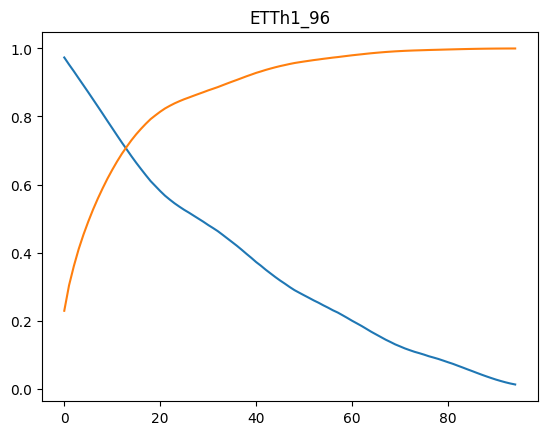

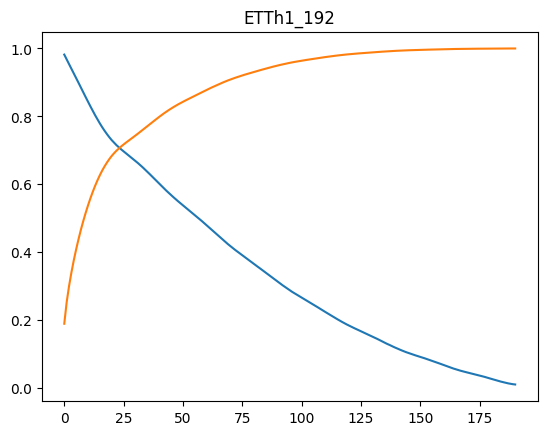

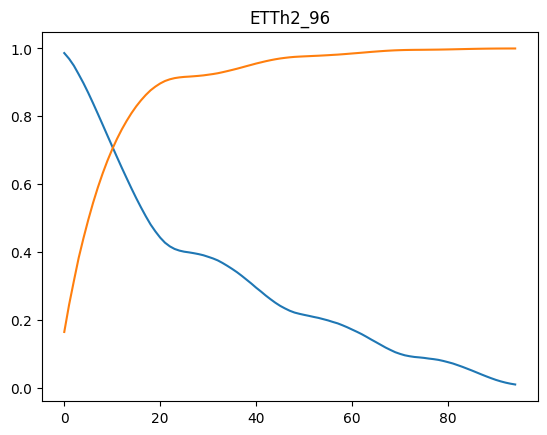

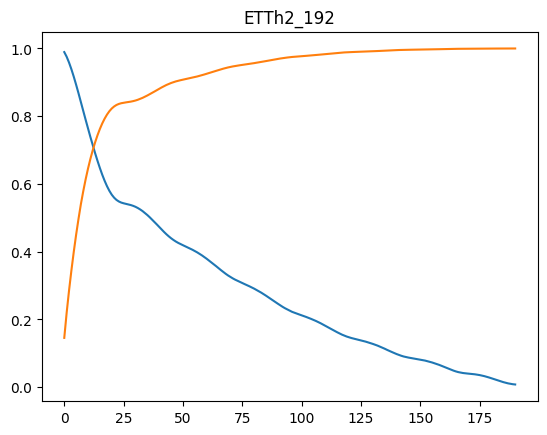

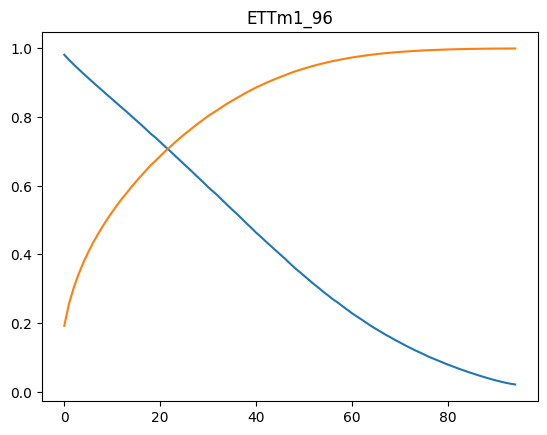

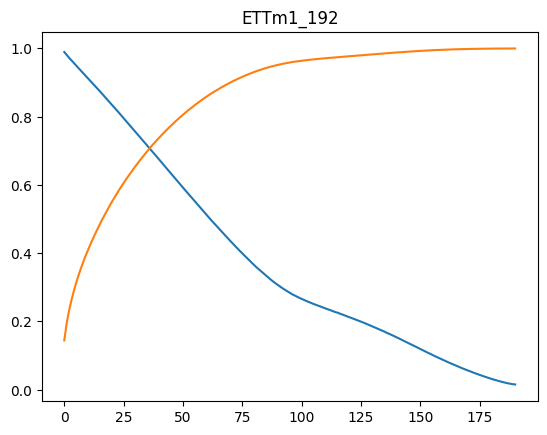

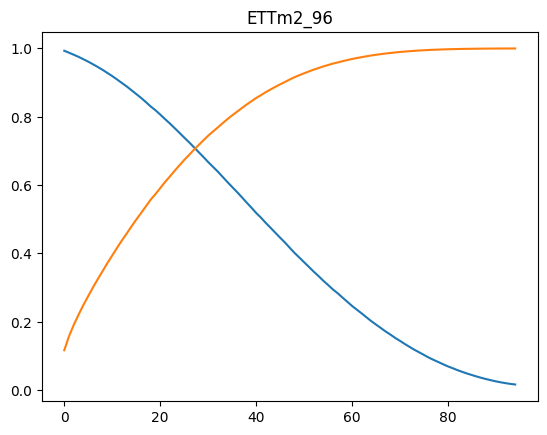

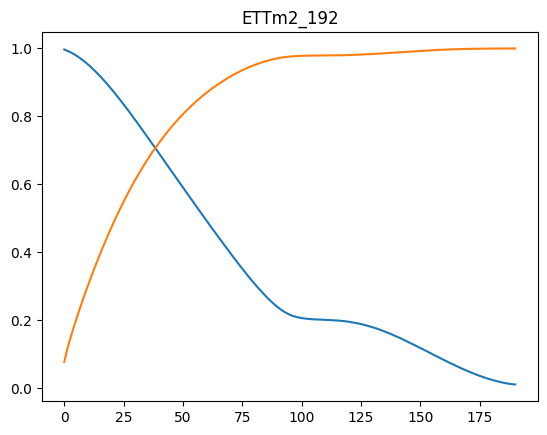

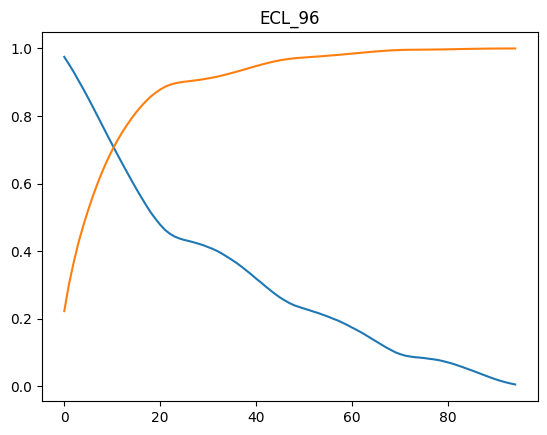

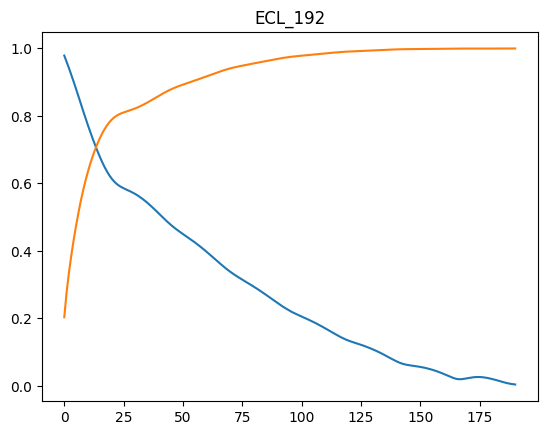

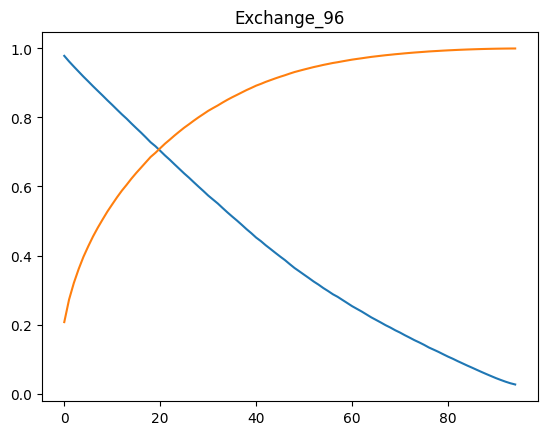

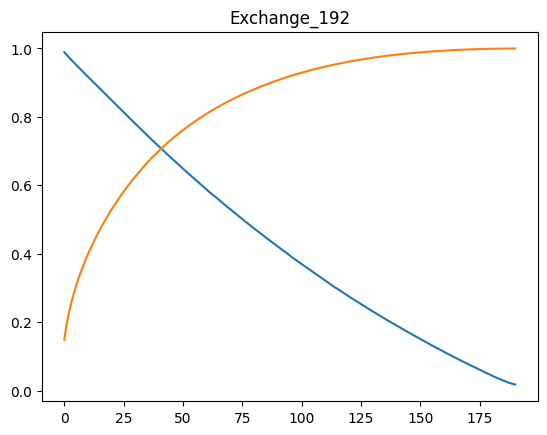

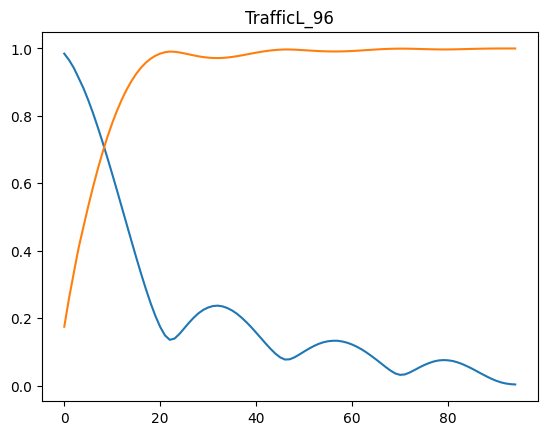

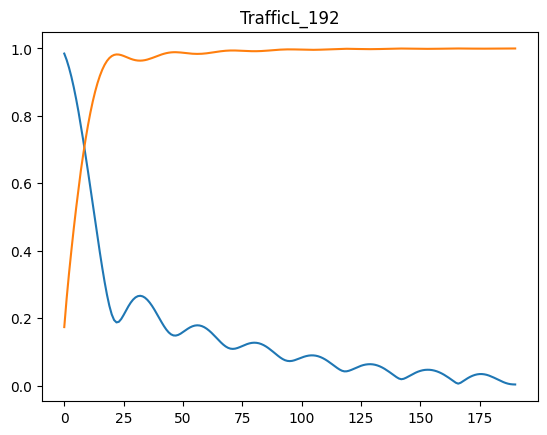

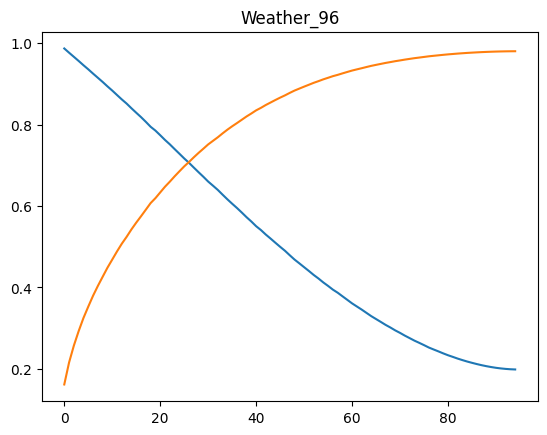

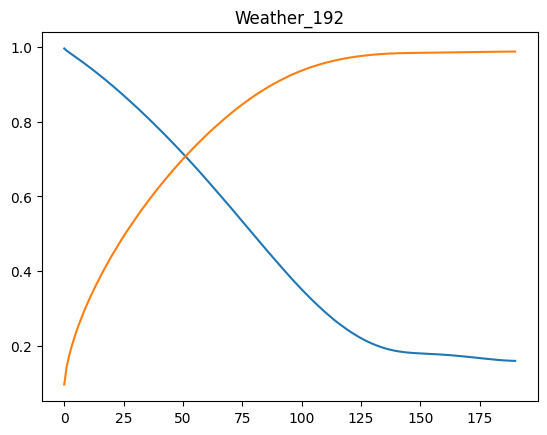

In [4]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# SAVE METRICS
ds = {
    "ETTh1": "etth1",
    "ETTh2": "etth2",
    "ETTm1": "ettm1",
    "ETTm2": "ettm2",
    "ECL": "electricity",
    "Exchange": "exchange_rate",
    "TrafficL": "traffic",
    "Weather": "weather",
}
pred_len = [96, 192]
save_dir = "/mnt/ExtraDisk/wcx/research/FrequencyDiffusion/savings"
all_df = []
for d in ds:
    real_d = ds[d]
    ds_df = []
    for pl in pred_len:
        result_path = os.path.join(save_dir, f"{real_d}_{pl}_S",f'stdratio_{real_d}_{pl}.pt')
        ns = torch.load(result_path).cpu().numpy().flatten()
        fig, ax = plt.subplots()
        ax.plot(ns)
        ax.plot(np.sqrt(1 - ns**2))
        ax.set_title(f"{d}_{pl}")
        # plt.close()
        